# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW04] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from typing import NoReturn

In [2]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [3]:
def get_precision_recall_accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    unique_classes = np.unique(y_true)
    recall, precision = [], []

    accuracy = np.mean(y_pred == y_true)
    for cl in unique_classes:
        cls_true = y_true == cl
        cls_pred = y_pred == cl

        tp = np.sum(cls_pred[cls_true])
        fp = np.sum(cls_pred[~ cls_true])
        fn = np.sum(~ cls_pred[cls_true])

        recall.append(tp / (tp + fn))
        precision.append(tp / (tp + fp))

    print(f"PRECISION: {precision}")
    print(f"RECALL: {recall}")
    print(f"ACCURACY: {accuracy}")
    

In [4]:
class Perceptron:
    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """

        self.iterations = iterations
        self.w = None
        self.mapto = {}
        self.mapfrom = {}


    def _add_itercept(self, X):
        return np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
        

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает простой перцептрон. 
        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """

        tmp = np.unique(y)
        self.mapto.update({-1: tmp[0], 1: tmp[1]})
        self.mapfrom.update({tmp[0]: -1, tmp[1]: 1})

        y_ = y.copy().reshape(-1, 1)
        for k, v in self.mapfrom.items():
            y_[y_ == k] = v

        X_ = self._add_itercept(X)
        self.w = np.zeros(shape=(X_.shape[1], 1))
        for _ in range(self.iterations):
            msk = (np.sign(X_ @ self.w) != y_).ravel()
            self.w += np.sum((X_ * y_)[msk], axis=0).reshape(-1, 1)


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """

        X_ = self._add_itercept(X)
        y_pred = (np.sign(X_ @ self.w).ravel()).astype(int)
        to_change = np.ones_like(y_pred, dtype=bool)
        for k, v in self.mapto.items():
            msk = y_pred == k
            y_pred[(msk & to_change)] = v
            to_change[msk & to_change] = False
        return y_pred
        

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

PRECISION: [0.9653465346534653, 0.9747474747474747]
RECALL: [0.975, 0.965]
ACCURACY: 0.97


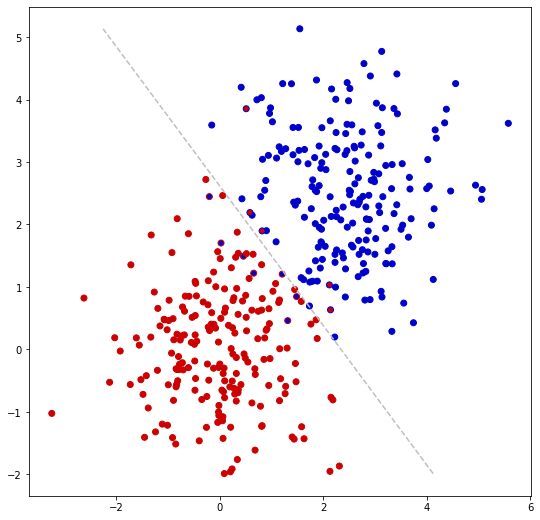

In [5]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]], random_state=42)
c = Perceptron(20)
c.fit(X, true_labels)
y_pred = c.predict(X)
get_precision_recall_accuracy(y_pred, true_labels)
visualize(X, true_labels, y_pred, c.w)

PRECISION: [0.9586206896551724, 0.7607843137254902]
RECALL: [0.695, 0.97]
ACCURACY: 0.8325


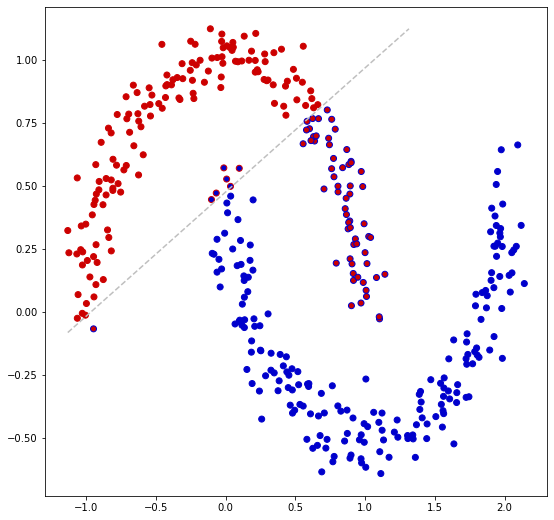

In [6]:
X, true_labels = make_moons(400, noise=0.075, random_state=16)
c = Perceptron()
c.fit(X, true_labels)
y_pred = c.predict(X)
get_precision_recall_accuracy(y_pred, true_labels)
visualize(X, true_labels, y_pred, c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [7]:
class PerceptronBest:

    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """

        self.iterations = iterations
        self.w = None
        self.best_acc = 0
        self.mapto = {}
        self.mapfrom = {}


    def _add_itercept(self, X):
        return np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))


    def get_accuracy(self, y_pred: np.ndarray, y_true: np.ndarray):
        return np.mean(y_pred == y_true)

    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает перцептрон.

        Для этого сначала инициализирует веса перцептрона, 
        а затем обновляет их в течении iterations итераций.

        При этом в конце обучения оставляет веса, 
        при которых значение accuracy было наибольшим.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        tmp = np.unique(y)
        self.mapto.update({-1: tmp[0], 1: tmp[1]})
        self.mapfrom.update({tmp[0]: -1, tmp[1]: 1})

        y_ = y.copy().reshape(-1, 1)
        for k, v in self.mapfrom.items():
            y_[y_ == k] = v
        X_ = self._add_itercept(X)
        w_ = np.zeros(shape=(X_.shape[1], 1))
        self.w = np.zeros_like(w_)
        
        for _ in range(self.iterations):
            msk = (np.sign(X_ @ w_) != y_).ravel()
            w_ += np.sum((X_ * y_)[msk], axis=0).reshape(-1, 1)

            tmp = self.get_accuracy(self._tmp_predict(X, w_), y)
            if tmp >= self.best_acc:
                self.best_acc = tmp
                self.w = w_.copy()
                

    def _tmp_predict(self, X, w):
        X_ = self._add_itercept(X)
        y_pred = (np.sign(X_ @ w).ravel()).astype(int)
        to_change = np.ones_like(y_pred, dtype=bool)
        for k, v in self.mapto.items():
            msk = y_pred == k
            y_pred[(msk & to_change)] = v
            to_change[msk & to_change] = False
        return y_pred

            
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """

        X_ = self._add_itercept(X)
        y_pred = (np.sign(X_ @ self.w).ravel()).astype(int)
        to_change = np.ones_like(y_pred, dtype=bool)
        for k, v in self.mapto.items():
            msk = y_pred == k
            y_pred[(msk & to_change)] = v
            to_change[msk & to_change] = False
        return y_pred

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

PRECISION: [0.9653465346534653, 0.9747474747474747]
RECALL: [0.975, 0.965]
ACCURACY: 0.97


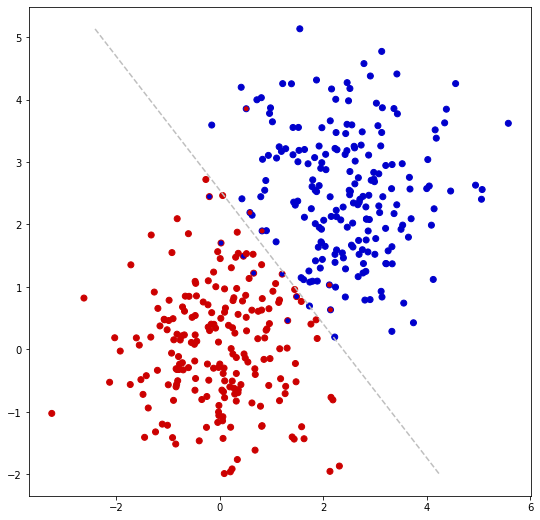

In [8]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]], random_state=42)
c = PerceptronBest()
c.fit(X, true_labels)
y_pred = c.predict(X)
get_precision_recall_accuracy(y_pred, true_labels)
visualize(X, true_labels, y_pred, c.w)

PRECISION: [0.9269662921348315, 0.8423423423423423]
RECALL: [0.825, 0.935]
ACCURACY: 0.88


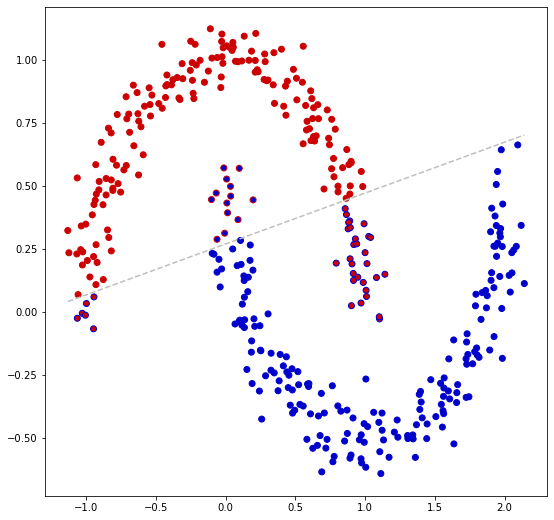

In [9]:
X, true_labels = make_moons(400, noise=0.075, random_state=16)
c = PerceptronBest()
c.fit(X, true_labels)
y_pred = c.predict(X)
get_precision_recall_accuracy(y_pred, true_labels)
visualize(X, true_labels, y_pred, c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [10]:
def transform_images(images: np.ndarray) -> np.ndarray:
    """
    Переводит каждое изображение в вектор из двух элементов.
        
    Parameters
    ----------
    images : np.ndarray
        Трехмерная матрица с черное-белыми изображениями.
        Её размерность: (n_images, image_height, image_width).

    Return
    ------
    np.ndarray
        Двумерная матрица с преобразованными изображениями.
        Её размерность: (n_images, 2).
    """
    n_images = images.shape[0]
    out = np.zeros(shape=(n_images, 2))
    out[:, 0] = np.abs(images - images[:, ::-1, :]).mean(axis=(1, 2))  # h
    # out[:, 1] = np.abs(images - images[:, :, ::-1]).mean(axis=(1, 2))  # v
    out[:, 1] = np.mean(images, axis=(1, 2))  # I
    return out
        

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что перцептрон детерминирован, а выборка должна разбиваться без перемешивания__

In [11]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

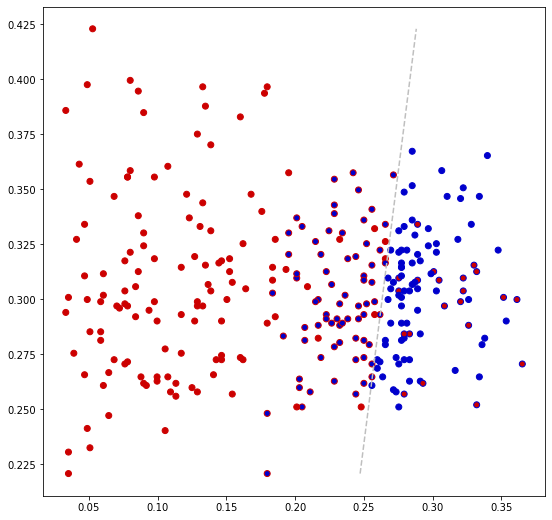

Accuracy: 0.6575342465753424


In [12]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

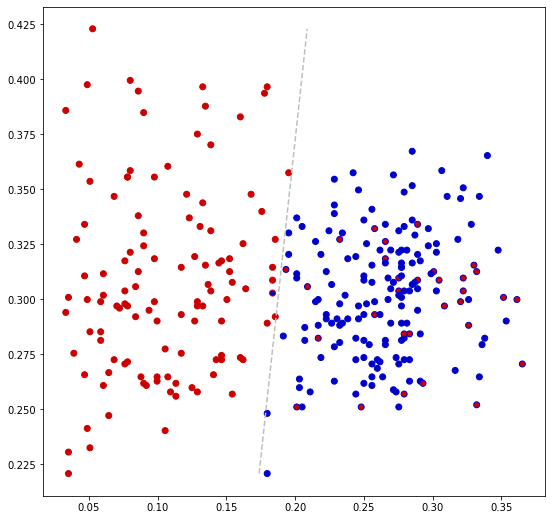

Accuracy: 0.9726027397260274


In [13]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [14]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6448279989424115


In [15]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.7141015975780269
